In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from bart_playground import *
import arviz as az

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [3]:
from ucimlrepo import fetch_ucirepo
import numpy as np
  
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features 
X = X.drop(columns=['Sex'])
y = abalone.data.targets 

X = X.values.astype(float)
y = np.array(y, dtype=np.float32).reshape(-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
n_chains = 4
chains_mtmh = []
proposal_probs = {"multi_grow": 0.25, "multi_prune": 0.25, "multi_change": 0.4, "multi_swap": 0.1}
for i in range(n_chains):
    bart = MultiBART(ndpost=1000, nskip=200, n_trees=100, proposal_probs=proposal_probs, multi_tries=10, random_state=i)
    bart.fit(X_train, y_train)
    sigmas = [trace.global_params['eps_sigma2'] for trace in bart.sampler.trace]
    chains_mtmh.append(sigmas)

# chains: shape (n_chains, n_samples)
chains_array = np.array(chains_mtmh)
idata = az.from_dict(posterior={"eps_sigma2": chains_array})
rhat = az.rhat(idata, var_names=["eps_sigma2"])
print("Gelman-Rubin R̂:", rhat)

Iterations: 100%|██████████| 1200/1200 [01:30<00:00, 13.24it/s]


Gelman-Rubin R̂: <xarray.Dataset> Size: 12B
Dimensions:           (eps_sigma2_dim_0: 1)
Coordinates:
  * eps_sigma2_dim_0  (eps_sigma2_dim_0) int32 4B 0
Data variables:
    eps_sigma2        (eps_sigma2_dim_0) float64 8B 1.024


In [5]:
import pandas as pd

# Collect move counts
selected = bart.sampler.move_selected_counts
success = bart.sampler.move_success_counts
accepted = bart.sampler.move_accepted_counts

# Combine into a DataFrame for easy viewing
df = pd.DataFrame({
    "selected": pd.Series(selected),
    "success": pd.Series(success),
    "accepted": pd.Series(accepted)
})

# Add success and acceptance rates
df["success_rate"] = df["success"] / df["selected"]
df["mh_ratio"] = df["accepted"] / df["success"]
df["accept_rate"] = df["accepted"] / df["selected"]

print(df)

              selected  success  accepted  success_rate  mh_ratio  accept_rate
multi_grow       30054    30054      8876      1.000000  0.295335     0.295335
multi_prune      30010    28456      8716      0.948217  0.306297     0.290437
multi_change     48094    45581     16412      0.947748  0.360062     0.341248
multi_swap       11842     3826      1008      0.323087  0.263461     0.085121


## Default BART

In [6]:
n_chains = 4
chains_default = []
proposal_probs = {"grow": 0.25, "prune": 0.25, "change": 0.4, "swap": 0.1}
for i in range(n_chains):
    bart_default = DefaultBART(ndpost=1000, nskip=200, n_trees=100, proposal_probs=proposal_probs, random_state=i)
    bart_default.fit(X_train, y_train)
    sigmas = [trace.global_params['eps_sigma2'] for trace in bart_default.sampler.trace]
    chains_default.append(sigmas)

# chains: shape (n_chains, n_samples)
chains_array = np.array(chains_default)
idata = az.from_dict(posterior={"eps_sigma2": chains_array})
rhat = az.rhat(idata, var_names=["eps_sigma2"])
print("Gelman-Rubin R̂:", rhat)

Iterations: 100%|██████████| 1200/1200 [00:10<00:00, 117.82it/s]

Gelman-Rubin R̂: <xarray.Dataset> Size: 12B
Dimensions:           (eps_sigma2_dim_0: 1)
Coordinates:
  * eps_sigma2_dim_0  (eps_sigma2_dim_0) int32 4B 0
Data variables:
    eps_sigma2        (eps_sigma2_dim_0) float64 8B 1.138


In [7]:
import pandas as pd

# Collect move counts
selected = bart_default.sampler.move_selected_counts
success = bart_default.sampler.move_success_counts
accepted = bart_default.sampler.move_accepted_counts

# Combine into a DataFrame for easy viewing
df = pd.DataFrame({
    "selected": pd.Series(selected),
    "success": pd.Series(success),
    "accepted": pd.Series(accepted)
})

# Add success and acceptance rates
df["success_rate"] = df["success"] / df["selected"]
df["mh_ratio"] = df["accepted"] / df["success"]
df["accept_rate"] = df["accepted"] / df["selected"]

print(df)

        selected  success  accepted  success_rate  mh_ratio  accept_rate
grow       29869    29869      7649      1.000000  0.256085     0.256085
prune      29808    27996      7489      0.939211  0.267503     0.251241
change     48268    45374      9107      0.940043  0.200710     0.188676
swap       12055     3978      1009      0.329988  0.253645     0.083700


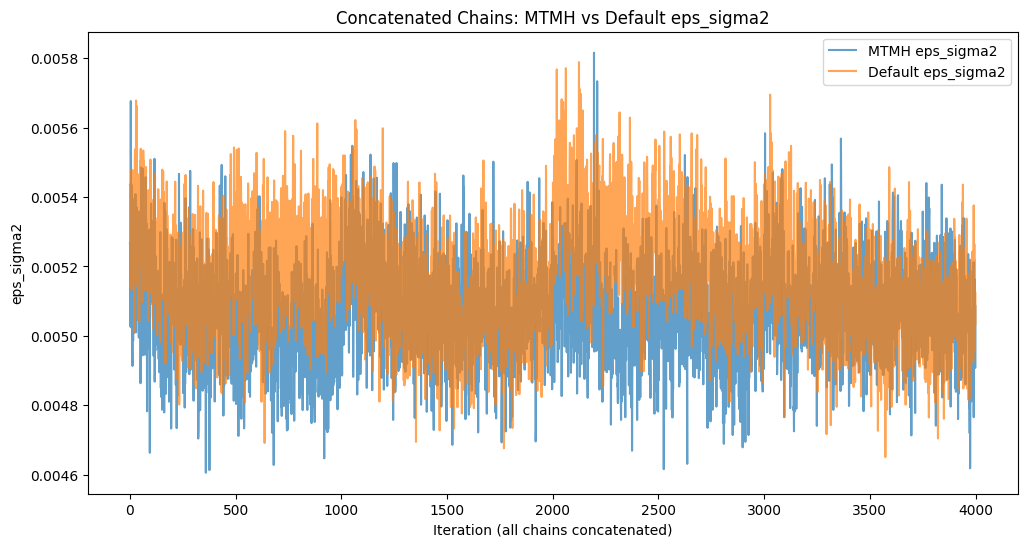

In [8]:
mtmh_long = np.concatenate(chains_mtmh)
default_long = np.concatenate(chains_default)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(mtmh_long, label='MTMH eps_sigma2', alpha=0.7)
plt.plot(default_long, label='Default eps_sigma2', alpha=0.7)
plt.xlabel('Iteration (all chains concatenated)')
plt.ylabel('eps_sigma2')
plt.legend()
plt.title('Concatenated Chains: MTMH vs Default eps_sigma2')
plt.show()